<a href="https://colab.research.google.com/github/ymann/CIS700-Deep-Learning/blob/master/HW2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deadline

This assignment will be due on **April 10, 2019**. Note that this is a group assignment and as such only **one** member per team should submit on canvas.

# Clone Git

Run the following to get the required files needed for this assignment. 

In [1]:

!git clone https://github.com/cis700/hw2-release.git
!mv hw2-release/* .
!rm -rf hw2-release/


Cloning into 'hw2-release'...
remote: Enumerating objects: 41332, done.
remote: Counting objects: 100% (41332/41332), done.
remote: Compressing objects: 100% (21056/21056), done.
remote: Total 41332 (delta 20276), reused 41331 (delta 20275), pack-reused 0
Receiving objects: 100% (41332/41332), 737.93 MiB | 15.16 MiB/s, done.
Resolving deltas: 100% (20276/20276), done.
Checking out files: 100% (41168/41168), done.
mv: cannot move 'hw2-release/DATASETS' to './DATASETS': Directory not empty


In [0]:
# Code referenced from https://gist.github.com/gyglim/1f8dfb1b5c82627ae3efcfbbadb9f514
import tensorflow as tf
import numpy as np
import scipy.misc 
try:
    from StringIO import StringIO  # Python 2.7
except ImportError:
    from io import BytesIO         # Python 3.x


class Logger(object):
    
    def __init__(self, log_dir):
        """Create a summary writer logging to log_dir."""
        self.writer = tf.summary.FileWriter(log_dir)

    def scalar_summary(self, tag, value, step):
        """Log a scalar variable."""
        summary = tf.Summary(value=[tf.Summary.Value(tag=tag, simple_value=value)])
        self.writer.add_summary(summary, step)

    def image_summary(self, tag, images, step):
        """Log a list of images."""

        img_summaries = []
        for i, img in enumerate(images):
            # Write the image to a string
            try:
                s = StringIO()
            except:
                s = BytesIO()
            scipy.misc.toimage(img).save(s, format="png")

            # Create an Image object
            img_sum = tf.Summary.Image(encoded_image_string=s.getvalue(),
                                       height=img.shape[0],
                                       width=img.shape[1])
            # Create a Summary value
            img_summaries.append(tf.Summary.Value(tag='%s/%d' % (tag, i), image=img_sum))

        # Create and write Summary
        summary = tf.Summary(value=img_summaries)
        self.writer.add_summary(summary, step)
        
    def histo_summary(self, tag, values, step, bins=1000):
        """Log a histogram of the tensor of values."""

        # Create a histogram using numpy
        counts, bin_edges = np.histogram(values, bins=bins)

        # Fill the fields of the histogram proto
        hist = tf.HistogramProto()
        hist.min = float(np.min(values))
        hist.max = float(np.max(values))
        hist.num = int(np.prod(values.shape))
        hist.sum = float(np.sum(values))
        hist.sum_squares = float(np.sum(values**2))

        # Drop the start of the first bin
        bin_edges = bin_edges[1:]

        # Add bin edges and counts
        for edge in bin_edges:
            hist.bucket_limit.append(edge)
        for c in counts:
            hist.bucket.append(c)

        # Create and write Summary
        summary = tf.Summary(value=[tf.Summary.Value(tag=tag, histo=hist)])
        self.writer.add_summary(summary, step)
        self.writer.flush()


In [0]:
import time, datetime
now = time.mktime(datetime.datetime.now().timetuple())
logger = Logger(f'./logs/2cccc_{now}/')

In [4]:
LOG_DIR = './logs'
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)

!if [ -f ngrok ] ; then echo "Ngrok already installed" ; else wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip > /dev/null 2>&1 && unzip ngrok-stable-linux-amd64.zip > /dev/null 2>&1 ; fi

Ngrok already installed


In [0]:
get_ipython().system_raw('./ngrok http 6006 &')

In [16]:
! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print('Tensorboard Link: ' +str(json.load(sys.stdin)['tunnels'][0]['public_url']))"

Tensorboard Link: http://1a722729.ngrok.io


In [7]:
# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'
!pip3 install https://download.pytorch.org/whl/cu100/torch-1.0.1-cp36-cp36m-linux_x86_64.whl
!pip3 install torchvision
  
import torch
device =  torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


**Collaboration Policy**

This homework assignment is meant to be done in **groups of 2**. You may work on this individually, but be warned that this homework assignment is extremely long and will be very difficult to do alone. We highly recommend you form groups.

You may collaborate with others on a high level, however, all LaTeX and code must be done independently of other groups. Groups who have been shown to be violating this policy will automatically receive a 0 for the assignment and be referred to the Office of Student Conduct. By submitting an assignment you agree that the work produced is your work and your work **only**.

**Late Policy**

With the exception of emergencies, any homework assignment submitted past the deadline will receive a 20% penalty for each day submitted late.

**Online Policy**

You may look up guides online that give you general advice / explanations on VAE's / GAN's and may look for instance at the PyTorch documentation but **may not** copy code from anywhere online. We will be transparent that there exists GAN and VAE solutions online (with their respective hyperparameters), however, copying any such code is **strictly prohibited**. We have spent many hours constructing this homework so that you do not have to utilize such resources and as such will be strict in enforcing this policy. Any violations will be directly reported to the OSC. 


# Image Classification

## Question 1. Build a CNN Dog Classifier

**Understanding the Dataset**

For this assignment, we are going to use the Stanford Dogs dataset [link](http://vision.stanford.edu/aditya86/ImageNetDogs/). We are providing a dataloader for you, which can be imported using the following code. Get familiar with the data loader, and visualize some dog pictures. 

**Q1a (2 pts):** Set the subset parameter for the data loader to 3 and visualize 5 pictures from the training set. Use subset = 3 for the rest of this question unless otherwise stated.

In [0]:
from dogloader import dogs
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
import torchvision.transforms as transforms
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision.utils import save_image
import torchvision
import torch.nn.functional as F
import time, datetime


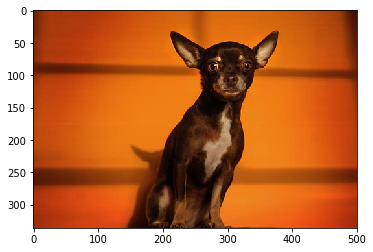

In [44]:
d = dogs('DATASETS')
input_size=224
input_transforms= transforms.Compose([
            transforms.Resize((input_size, input_size)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])])
dog_train_dataset = dogs('DATASETS', transform=input_transforms, train=True, subset=3)
dog_test_dataset = dogs('DATASETS', transform=input_transforms, train=False, subset=3)

train_images = d.load_split()
image,index = train_images[4]
plt.imshow(mpimg.imread('DATASETS/StanfordDogs/Images/'+image+'.jpg'))
# image,index = train_images[1]
# plt.imshow(mpimg.imread('DATASETS/StanfordDogs/Images/'+image+'.jpg'))
# image,index = train_images[2]`
# plt.imshow(mpimg.imread('DATASETS/StanfordDogs/Images/'+image+'.jpg'))
# image,index = train_images[3]
# plt.imshow(mpimg.imread('DATASETS/StanfordDogs/Images/'+image+'.jpg'))
# image,index = train_images[4]
# plt.imshow(mpimg.imread('DATASETS/StanfordDogs/Images/'+image+'.jpg'))
# print(mpimg.imread('DATASETS/StanfordDogs/Images/'+image+'.jpg').view(images.size(0), -1))
# # images.view(images.size(0), -1).to(device), labels.to(device)
# d.train = False
# test_images = d.load_split()

**Logistic Regression Classification**

**Q1b (2 pts):** Use PyTorch to create a Logistic Regression model to classify the Dog Datset. Plot the training curve and report the test accuracy.

In [0]:
# Fix train/ test data
for i in range(len(train_images)):
  label = train_images[i][1]
  img_orig = d.__getitem__(i)[0]
#   img_orig = img_orig.resize((100,100))
  img = np.array(img_orig).astype(np.float32)
  train_images[i] = (img, label)
  
for i in range(len(test_images)):
  label = test_images[i][1]
  img_orig = d.__getitem__(i)[0]
#   img_orig = img_orig.resize((100,100))
  img = np.array(img_orig).astype(np.float32)
  test_images[i] = (img, label)

In [0]:
import torch
import torch.nn as nn
from torch.autograd import Variable

class LogRegression(nn.Module):
    def __init__(self):
        super(LogRegression, self).__init__()
        self.linear = nn.Linear(150528, 3)
    
    def forward(self, x):
        out = self.linear(x)
        F.softmax(out)
        return out


In [0]:
num_epochs = 20
batch_size = 50
learning_rate = 0.0001
input_size = 30000
train_loader = torch.utils.data.DataLoader(dataset=dog_train_dataset, 
                                          batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=dog_test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=True)
iter_per_epoch = len(train_loader)

In [0]:
def train_model(model, input_size):
  now = time.mktime(datetime.datetime.now().timetuple())
  logger = Logger(f'./logs/2cccc_{now}/')

  criterion = nn.CrossEntropyLoss()  
  optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)  

  # img = np.array(train_images[0][0])
  # print(img.view(img.size, -1))
  # print(train_images[0][0])
  # print(train_images[1][0].size)

  for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
  # #         print(images)
  #         print(images.view(images.size(0), -1))
  #     print(images[0].type())
      images, labels = images.view(-1,input_size).to(device), labels.to(device)
  #     print("b: ", images.size())
      optimizer.zero_grad()
      outputs = model(images)
#       print(outputs.size())
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()

       # Compute accuracy
      _, argmax = torch.max(outputs, 1)
      accuracy = (labels == argmax.squeeze()).float().mean()
      del images, labels

      # ================================================================== #
      #                        Tensorboard Logging                         #
      # ================================================================== #
      
      # 1. Log scalar values (scalar summary)
      info = { 'loss': loss.item(), 'accuracy': accuracy.item() }
      for tag, value in info.items():
#         print(value, (epoch) * iter_per_epoch + i+1)
        logger.scalar_summary(tag, value, (epoch) * iter_per_epoch + i+1)

In [0]:
def test_model(model, input_size):
  criterion = torch.nn.CrossEntropyLoss()  
  optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)  

  for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(test_loader):

      images, labels = images.view(-1,input_size).to(device), labels.to(device)
      outputs = model(images)
      loss = criterion(outputs, labels)
      
       # Compute accuracy
      _, argmax = torch.max(outputs, 1)
      accuracy = (labels == argmax.squeeze()).float().mean()
      del images, labels
#       # ================================================================== #
#       #                        Tensorboard Logging                         #
#       # ================================================================== #

#       # 1. Log scalar values (scalar summary)
#       info = { 'loss': loss.item(), 'accuracy': accuracy.item() }
#       for tag, value in info.items():
#         logger.scalar_summary(tag, value, (epoch) * iter_per_epoch + i+1)

  return accuracy

In [0]:
model = LogRegression().to(device)
train_model(model, 150528)
test_model(model,150528)

NameError: ignored

**Feed Forward Neural Network Classification**

**Q1c (3 pts):** Create a Feed Forward neural network to classify the Dog Dataset. Plot the training curve and report the test accuracy.

In [0]:
import torch
import torch.nn as nn
from torch.autograd import Variable

class NN(nn.Module):
    def __init__(self):
        super(NN, self).__init__()
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(150528, 1000)
        self.fc2 = nn.Linear(1000, 150)
        self.fc3 = nn.Linear(150, 3)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return F.softmax(x)

In [0]:
model = NN().to(device)
train_model(model, 150528)
test_model(model,150528)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


tensor(0.6292, device='cuda:0')

**CNN Classification**

**Q1c (3 pts):** Create a CNN to classify the Dog Dataset. Plot the training curve and report the test accuracy.

In [0]:
def train_model_cnn(model):
  now = time.mktime(datetime.datetime.now().timetuple())
  logger = Logger(f'./logs/2cccc_{now}/')

  criterion = nn.MSELoss()  
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  

  for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
      images, labels = images.view(-1,3,224,224).to(device), labels.to(device)
      optimizer.zero_grad()
      outputs = model(images)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()

       # Compute accuracy
      _, argmax = torch.max(outputs, 1)
      accuracy = (labels == argmax.squeeze()).float().mean()
      del images, labels
      # ================================================================== #
      #                        Tensorboard Logging                         #
      # ================================================================== #

      # 1. Log scalar values (scalar summary)
      info = { 'loss': loss.item(), 'accuracy': accuracy.item() }
      for tag, value in info.items():
        logger.scalar_summary(tag, value, (epoch) * iter_per_epoch + i+1)

In [0]:
def test_model_cnn(model):
  criterion = torch.nn.MSELoss()  
#   for epoch in range(num_epochs):
  for i, (images, labels) in enumerate(test_loader):

    images, labels = images.view(-1,3,224,224).to(device), labels.to(device)
    outputs = model(images)
    loss = criterion(outputs, labels)

     # Compute accuracy
    _, argmax = torch.max(outputs, 1)
    accuracy = (labels == argmax.squeeze()).float().mean()
    del images, labels
#       # ================================================================== #
#       #                        Tensorboard Logging                         #
#       # ================================================================== #

#       # 1. Log scalar values (scalar summary)
#       info = { 'loss': loss.item(), 'accuracy': accuracy.item() }
#       for tag, value in info.items():
#         logger.scalar_summary(tag, value, (epoch) * iter_per_epoch + i+1)

  return accuracy

In [0]:
from torch.autograd import Variable
import torch.nn as nn

class CNN(torch.nn.Module):
        
    def __init__(self):
        super(CNN, self).__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(3,8,kernel_size=3,stride=1,padding=2),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(8,16,kernel_size=3,stride=1,padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(16,32,kernel_size=3,stride=1,padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(32,64,kernel_size=3,stride=1,padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3,stride=2)
        )
        self.fc1 = nn.Linear(64*15*15, 1024)
        self.fc2 = nn.Linear(1024, 120)
        
    def forward(self, x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.conv3(out)
        out = self.conv4(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc1(out)
        out = self.fc2(out)
        return(F.softmax(out))


In [26]:
model = CNN().to(device)
train_model_cnn(model)
test_model_cnn(model)

AttributeError: ignored

**Q1d (5 pts):** Use the same architecture from the previous question (except for the last linear layer--change the output number of classes), but set the subset = 120 this time. Train a new model, plot your training accuracy and report your final test accuracy. What do notice about the training and testing accuracy? Keep a note of your final testing accuracy. 

In [0]:
input_size = 224
input_transforms = transforms.Compose([
            transforms.Resize((input_size, input_size)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])])

In [0]:
num_epochs = 20
batch_size = 100
learning_rate = 0.001

dog_train_dataset = dogs('DATASETS', transform=input_transforms, train=True)
dog_test_dataset = dogs('DATASETS', transform=input_transforms, train=False)

train_loader = torch.utils.data.DataLoader(dataset=dog_train_dataset, 
                                               batch_size=batch_size, 
                                               shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=dog_test_dataset, 
                                               batch_size=batch_size, 
                                               shuffle=True)

iter_per_epoch = len(train_loader)

In [0]:
from torch.autograd import Variable
import torch.nn as nn

class CNN(torch.nn.Module):
        
    def __init__(self):
        super(CNN, self).__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(3,16,kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.BatchNorm2d(16),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(16,32,kernel_size=3),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(32,64,kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(64,128,kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(128,256,kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.fc1 = nn.Linear(256*5*5, 120)
        self.d = nn.Dropout(0.2)
#         self.fc2 = nn.Linear(1024, 120)
        
    def forward(self, x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.conv5(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc1(self.d(out))
#         out = self.fc2(out)
        return(F.softmax(out))


In [33]:
model = CNN().to(device)
train_model_cnn(model)
test_model_cnn(model)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:52: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


RuntimeError: ignored

## Question 2. Transfer Learning on ResNets for Image Classification 

In this question we will explore different ways to bootstrap your image classifier when training examples are scarce. For the dog dataset, we have around 100 training images for each class, and variation between each class is limited (all dogs). Due to the limited number of training examples, building a high-performing image classifier is challenging. 

ImageNet is one of the most popular computer vision data sets. It  contains 10 million images in total from multiple different categories. The Stanford Dogs dataset we are using is a subset from ImageNet, orginally intended for fine-grained object classification tasks. PyTorch provides ResNets that are pre-trained on ImageNet, and using this pretrained model, we can build a dog classifier much more easily. 

**Note:** In Question 2 set subset = 120 (the default).

**Q2 (15 pts):** In the code snippet below, load a pre-trained ResNet model and swap out the last fully connected layer from the network with your own classification layer. Train the network, plot your training accuracy, and report your final test accuracy. Your test accuracy should be at least 70%. A few tips:

* After the last fully connected layer of the network, remember to freeze the network except for the last layer to speed up the training.

* Pretrained ResNet models assumes that input is normalized in the following fashion, and is of the size at least 224.

In [0]:
input_size = 224
input_transforms = transforms.Compose([
            transforms.Resize((input_size, input_size)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])])

In [0]:
res_num_epochs = 5
res_batch_size = 50
learning_rate = 0.0001

dog_train_dataset = dogs('DATASETS', transform=input_transforms, train=True)
dog_test_dataset = dogs('DATASETS', transform=input_transforms, train=False)

res_train_loader = torch.utils.data.DataLoader(dataset=dog_train_dataset, 
                                               batch_size=res_batch_size, 
                                               shuffle=True)
res_test_loader = torch.utils.data.DataLoader(dataset=dog_test_dataset, 
                                               batch_size=res_batch_size, 
                                               shuffle=True)

iter_per_epoch = len(res_train_loader)

In [0]:
def test_model_res(model):
  now = time.mktime(datetime.datetime.now().timetuple())
  logger = Logger(f'./logs/2cccc_{now}/')
  criterion = torch.nn.CrossEntropyLoss()  
  optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)  

  for epoch in range(res_num_epochs):
    for i, (images, labels) in enumerate(res_test_loader):
      images, labels = images.to(device), labels.to(device)
      outputs = model(images)
      loss = criterion(outputs, labels)

       # Compute accuracy
      _, argmax = torch.max(outputs, 1)
      accuracy = (labels == argmax.squeeze()).float().mean()
      
      #       # ================================================================== #
#       #                        Tensorboard Logging                         #
#       # ================================================================== #

#        #1. Log scalar values (scalar summary)
      
#       info = { 'loss': loss.item(), 'accuracy': accuracy.item() }
#       for tag, value in info.items():
#         logger.scalar_summary(tag, value, (epoch) * iter_per_epoch + i+1)

    return accuracy

In [0]:
import torch

def train_model_res(model):
  now = time.mktime(datetime.datetime.now().timetuple())
  logger = Logger(f'./logs/2cccc_{now}/')

  criterion = nn.CrossEntropyLoss()  
  optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)  

  for epoch in range(res_num_epochs):
    for i, (images, labels) in enumerate(res_train_loader):
      images, labels = images.to(device), labels.to(device)
      outputs = model(images)
      loss = criterion(outputs, labels)
    
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

       # Compute accuracy
      _, argmax = torch.max(outputs, 1)
      accuracy = (labels == argmax.squeeze()).float().mean()
      print(loss)

      # ================================================================== #
      #                        Tensorboard Logging                         #
      # ================================================================== #

      # 1. Log scalar values (scalar summary)
      info = { 'loss': loss.item(), 'accuracy': accuracy.item() }
      for tag, value in info.items():
        logger.scalar_summary(tag, value, (epoch) * iter_per_epoch + i+1)

In [0]:
import torchvision.models as models
import torch.nn as nn

resnet18 = models.resnet18(pretrained=True)

# print(resnet18.__dict__) # ('fc', Linear(in_features=512, out_features=1000, bias=True)

# Freeze all layers
for params in resnet18.parameters():
   params.requires_grad = False
    
# Substitute last layer with unfrozen linear unit
resnet18.fc = nn.Linear(in_features=resnet18.fc.in_features, out_features=120)
resnet18.train()
train_model_res(resnet18.to(device))

In [0]:
resnet18.eval()
test_model_res(resnet18.to(device)) # gave test accuracy of exactly 70 lol

## Question 3. Generative Models: Convolutional Autoencoders and Variational Autoencoders

In this question you will create a Convolutional AutoEncoder (CAE) and a Variational AutoEncoder (VAE) for the Stanford Dogs Dataset. Before you em**bark** on this part, please read the [slides](https://www.seas.upenn.edu/~cis700dl/slides/7M.pptx) thoroughly to ensure that you understand how an autoencoder works (i.e. the loss function and general structure). The slides provide some sample code you follow, but note that you may need to create a bigger network. Also, the sample code on the slides only output a black and white image, but you should create a network that output color images. 

To get good reconstruction results, the AE might take a long time to train (for instance > 2 hours); however, you should be able to tell whether or not your network is learning much earlier than that. Be sure to not just look at your loss, but also periodically examine your image outputs to ensure that they are becoming sharper and sharper representations of your input image. The choice of when to stop your AE's training is up to your discretion (however the output should be reasonably close). 

**Note:** In this section set subset = 120 (the default)

**Q3a (10 pts):** After creating your AE, plot the resulting training curve and in your report give 5 examples of the input and corresponding reconstruction.





In [0]:
class cae(nn.Module):
    def __init__(self):
        super(cae, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3,192,kernel_size=2,stride=1,padding=1), #(224,224)
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=2), #(112,112)
            nn.Conv2d(192,96,kernel_size=3,stride=3,padding=1), #(38,38)
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=2), #(19,19)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(96, 192, kernel_size=2, stride=3, padding=1), #(54,54)
            nn.ReLU(True),
            nn.ConvTranspose2d(192, 96, kernel_size=5, stride=2), #(111,111)
            nn.ReLU(True),
            nn.ConvTranspose2d(96, 3, kernel_size=4, stride=2), #(224,224)
            nn.Tanh()

        )
        
    def decode(self, x):
      return self.decoder(x)
            
    def encode(self, x):
      return self.encoder(x)
 
    def forward(self, x):
        x = self.encoder(x)
#         print(x.size())
        x = self.decoder(x)
        return x

def to_img(x):
    x = x.clamp(0, 1)
    x = x.view(x.size(0), 3, 224, 224)
    return x

In [0]:
# class cae(nn.Module):
#     def __init__(self):
#         super(cae, self).__init__()
#         self.encoder = nn.Sequential(
#             nn.Conv2d(3,32,kernel_size=4,stride=2,padding=1), #(112,12)
#             nn.ReLU(Truex,
#             nn.MaxPool2d(2, stride=2), #(56,56)
#             nn.Conv2d(32,64,kernel_size=4,stride=2,padding=1), #(28,28)
#             nn.ReLU(True),
#             nn.MaxPool2d(2, stride=2), #(14,14)
#         )
#         self.decoder = nn.Sequential(
#             nn.ConvTranspose2d(64, 32, kernel_size=2, stride=3, padding=1), #(54,54)
#             nn.ReLU(True),
#             nn.ConvTranspose2d(32, 16, kernel_size=5, stride=2), #(111,111)
#             nn.ReLU(True),
#             nn.ConvTranspose2d(16, 3, kernel_size=4, stride=2), #(224,224)
#             nn.Tanh()

#         )
    
#     def decode(self, x):
#       return self.decoder(x)
            
#     def encode(self, x):
#       return self.encoder(x)
            
#     def forward(self, x):
#         x = self.encoder(x)
# #         print(x.size())
#         x = decode(x)
#         return x

# def to_img(x):
# #     x = 0.5 * (x + 1)
#     x = x.clamp(0, 1)
#     x = x.view(x.size(0), 3, 224, 224)
#     return x

In [0]:
!rm -rf dc_img
!mkdir dc_img

In [47]:
now = time.mktime(datetime.datetime.now().timetuple())
logger = Logger(f'./logs/2cccc_{now}/')
num_epochs=10
model = cae().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate,
                             weight_decay=1e-5)
for epoch in range(num_epochs):
    for i, data in enumerate(train_loader):
        img, _ = data
        img = Variable(img).to(device)
        # ===================forward=====================
        output = model(img)
        loss = criterion(output, img)
        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # ===================log========================
         # Compute accuracy
      #     _, argmax = torch.max(outputs, 1)
      #     accuracy = (labels == argmax.squeeze()).float().mean()

        # ================================================================== #
        #                        Tensorboard Logging                         #
        # ================================================================== #

        # 1. Log scalar values (scalar summary)
        info = { 'loss': loss.item() }
        for tag, value in info.items():
          logger.scalar_summary(tag, value, (epoch) * iter_per_epoch + i+1)
          
#     print('epoch [{}/{}], loss:{:.4f}'
#           .format(epoch+1, num_epochs, loss.data))
#     pic = to_img(output.cpu().data)
#     real_pic = to_img(img)
#     save_image(pic, './dc_img/image_{}.png'.format(epoch))
#     save_image(real_pic, './dc_img/real_image_{}.png'.format(epoch))
        
    


torch.save(model.state_dict(), './conv_autoencoder.pth')


RuntimeError: ignored

In [0]:
torch.cuda.empty_cache()

**Q3b (5 pts):** An interesting property of AE's is that the "code" vector has additive and subtractive properties. Perform addition and subtraction on different code vectors and pass it through your decoder to create a new image. Explain why the image looks as it does. 

In [0]:
x1 = train_loader.dataset[0][0].to(device)
x2 = train_loader.dataset[1][0].to(device)
# x = pic1 + pic2
# x = x.to(device)

In [0]:
y1 = model.encode(x1.view(1, 3, 224, 224))
y2 = model.encode(x2.view(1, 3, 224, 224))
y = y1 + y2

In [0]:
print(y.size())

torch.Size([1, 96, 19, 19])


In [0]:
# y3 = model.decode(y)
# # pic = to_img(output.cpu().data)
# # save_image(pic, './dc_img/added_image_{}.png'.format(epoch))
# plt.imshow(train_loader.dataset[0][0])
# # plt.show()
# # plt.imshow(train_loader.dataset[1][0]) 
# img1 = y3.view(y3.shape[1], y3.shape[2], y3.shape[0])
# img = to_img(y3.cpu().data)
# img3 = to_img(x1.cpu().data)
save_image(x1, './dc_img/added_image_11.png'.format(epoch))
# # y3.size()

# train_loader.dataset[1][0]

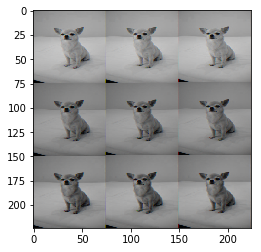

In [0]:
img2 = pic2.view(pic2.shape[1], pic2.shape[2], pic2.shape[0])
plt.imshow(img2)


**Q3c (10 pts optional extra credit)**: Using an autoencoder can be a great way to get increased classification accuracy without actually needing more data. For extra credit, use the AE that you just constructed to seed the network and then train on all 120 classes of the Stanford Dog's Dataset. Plot the training curve and test accuracy 

*(Hint: Employ a similar strategy to ResNet to remove the last layer of your AE and instead replace it with a fully connected layer of size 120)*

In [0]:
class cae(nn.Module):
    def __init__(self):
        super(cae, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3,192,kernel_size=2,stride=1,padding=1), #(224,224)
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=2), #(112,112)
            nn.Conv2d(192,96,kernel_size=3,stride=3,padding=1), #(38,38)
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=2), #(19,19)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(96, 192, kernel_size=2, stride=3, padding=1), #(54,54)
            nn.ReLU(True),
            nn.ConvTranspose2d(192, 96, kernel_size=5, stride=2), #(111,111)
            nn.ReLU(True),
            nn.ConvTranspose2d(96, 3, kernel_size=4, stride=2), #(224,224)
            nn.Tanh()

        )

    def forward(self, x):
        x = self.encoder(x)
#         print(x.size())
        x = self.decoder(x)
        return x

def to_img(x):
    x = 0.5 * (x + 1)
    x = x.clamp(0, 1)
    x = x.view(x.size(0), 3, 224, 224)
    return x

**Q3d (20 pts):** Variational AutoEncoders, as covered in class, learn the probability distribution of the inputs and can be used to generate novel images.  We can further pass convolutional features into a VAE to create a convolutional VAE.  Convert your CAE from the previous question to a convolutional VAE by executing the following steps:

* In the encoder, generate two tensors of the same length, representing mean and standard deviation of the latent probability distribution. 

* Sample from a normal distribution from the learned mean and std to generate the final encoding tensor -- this is the reparametrization trick discussed in lecture.

* Decode from the encoding tensor just as in the convolutional autoencoder. 

* Change your loss function from MSE reconstruction loss to the objective function for VAE:
 * Reconstrucation Loss: binary_cross_entropy loss between original and reconstructed image. 
 * Regularization on the sampled latent normal distribution 

$$ L_{reconstruciton} = -\frac{1}{n} \sum_{i}^{n}(x_i log(f(z_i)) + (1-x_i) log(1-f(z_i))) $$
$$ L_{regularization} = \frac{1}{2n}\sum_{i}^{n}(\mu_{i}^{2} + \sigma_{i}^2 - log(\sigma_i^2)- 1)$$
$$ L_{loss} =L_{regularization} +  L_{reconstruction}$$






In [0]:
input_size = 224
input_transforms = transforms.Compose([
            transforms.Resize((input_size, input_size)),
            transforms.ToTensor()])

In [0]:
res_num_epochs = 5
res_batch_size = 50
learning_rate = 0.0001

dog_train_dataset = dogs('DATASETS', transform=input_transforms, train=True)
dog_test_dataset = dogs('DATASETS', transform=input_transforms, train=False)

train_loader = torch.utils.data.DataLoader(dataset=dog_train_dataset, 
                                               batch_size=res_batch_size, 
                                               shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=dog_test_dataset, 
                                               batch_size=res_batch_size, 
                                               shuffle=True)

iter_per_epoch = len(train_loader)

In [0]:
# class vae(nn.Module):
#     def __init__(self):
#         super(vae, self).__init__()
#         self.encoder = nn.Sequential(
#             nn.Conv2d(3,32,kernel_size=4,stride=2,padding=1), #(111,111)
#             nn.ReLU(True),
#             nn.MaxPool2d(2, stride=2), #(55,55)
#             nn.Conv2d(32,64,kernel_size=3,stride=2,padding=1), #(28,28)
#             nn.ReLU(True),
#             nn.MaxPool2d(2, stride=2), #(14,14)
#             nn.Conv2d(64,128,kernel_size=2,stride=1,padding=1), #(15,15)
#             nn.ReLU(True),
#             nn.MaxPool2d(2, stride=2), #(7,7)
#             nn.Conv2d(128,256,kernel_size=3,stride=2,padding=1), #(4,4) <- correct
#             nn.ReLU(True),
#         )
#         self.relu = nn.ReLU()
#         self.fc1 = nn.Linear(4*4*256, 500)
#         self.fc2 = nn.Linear(4*4*256, 500)
#         self.fc3 = nn.Linear(500,10*10*256)
#         self.decoder = nn.Sequential(
#             nn.ConvTranspose2d(256, 128, kernel_size=4, stride=3, padding=1), #(29,29)
#             nn.ReLU(True),
#             nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2, padding=1), #(56,56)
#             nn.ReLU(True),
#             nn.ConvTranspose2d(64, 32, kernel_size=5, stride=2, padding=1), #(113,113)
#             nn.ReLU(True),
#             nn.ConvTranspose2d(32, 3, kernel_size=2, stride=2, padding=1), #(224,224)
#             nn.Sigmoid()
#         )

#     def forward(self, x):
#         mu, logvar = self.encode(x)
#         z = self.reparametrize(mu, logvar)
#         z = self.relu(self.fc3(z))
# #         print(z.size())
#         z = z.view(50,256,10,10)
#         return self.decoder(z), mu, logvar

#     def encode(self, x):
#       out = self.encoder(x)
#       out = out.view(out.size(0), -1)
#       return self.fc1(out), self.fc2(out)
      
#     def reparametrize(self, mu, logvar):
#       std = logvar.mul(0.5).exp_()
# #       eps = torch.FloatTensor(std.size()).normal_()
#       eps = torch.FloatTensor(std.size()).normal_().to(device)
#       to_return = eps.mul(std).add_(mu)
#       return to_return
       
# def to_img(x):
#     x = 0.5 * (x + 1)
#     x = x.clamp(0, 1)
#     x = x.view(x.size(0), 3, 224, 224)
#     return x

In [0]:
class vae(nn.Module):
    def __init__(self):
        super(vae, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3,32,kernel_size=4,stride=2,padding=1), #(112,112)
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            nn.Conv2d(32,64,kernel_size=4,stride=2,padding=1), #(56,56)
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.Conv2d(64,128,kernel_size=4,stride=2,padding=1), #(28,28)
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.Conv2d(128,256,kernel_size=4,stride=2,padding=1), #(14,14) <- correct
            nn.BatchNorm2d(256),
            nn.ReLU(True),
        )
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(14*14*256, 2048)
        self.fc2 = nn.Linear(14*14*256, 2048)
        self.fc3 = nn.Linear(2048,14*14*256)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=5, stride=2, padding=1), #(29,29)
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2, padding=1), #(56,56)
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 32, kernel_size=5, stride=2, padding=1), #(113,113)
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 3, kernel_size=2, stride=2, padding=1), #(224,224)
            nn.Sigmoid()
        )

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparametrize(mu, logvar)
        z = self.relu(self.fc3(z))
#         print(z.size())
        z = z.view(50,256,14,14)
        return self.decoder(z), mu, logvar

    def encode(self, x):
      out = self.encoder(x)
      out = out.view(out.size(0), -1)
      return self.fc1(out), self.fc2(out)
      
    def reparametrize(self, mu, logvar):
      std = logvar.mul(0.5).exp_()
#       eps = torch.FloatTensor(std.size()).normal_()
      eps = torch.FloatTensor(std.size()).normal_().to(device)
      to_return = eps.mul(std).add_(mu)
      return to_return
       
def to_img(x):
    x = x.clamp(0, 1)
    x = x.view(x.size(0), 3, 224, 224)
    return x

In [0]:
def criterion_vae(output, img, mu, logvar):
  criterion1 = nn.BCELoss(reduction='sum')
  l_recon = criterion1(output, img)
  l_reg = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
  return l_recon + l_reg

In [0]:
!rm -rf vae
!mkdir vae

In [0]:
now = time.mktime(datetime.datetime.now().timetuple())
logger = Logger(f'./logs/2cccc_{now}/')
num_epochs=30
# model = vae()
model = vae().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate,
                             weight_decay=1e-5)
for epoch in range(num_epochs):
    for i, data in enumerate(train_loader):
        img, label = data
#         img = Variable(img)
#         print(img[0])
        img = Variable(img).to(device)
        # ===================forward=====================
        output, mu, logvar = model(img)
#         print(img.size(), output.size())
#         print(output[0])
        loss = criterion_vae(output, img, mu, logvar)
        del img, label
        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # ===================log========================
    #      # Compute accuracy
    #     _, argmax = torch.max(outputs, 1)
    #     accuracy = (labels == argmax.squeeze()).float().mean()
        # ================================================================== #
        #                        Tensorboard Logging                         #
        # ================================================================== #

        # 1. Log scalar values (scalar summary)
        info = { 'loss': loss.item() }
        for tag, value in info.items():
          logger.scalar_summary(tag, value, (epoch) * iter_per_epoch + i+1)
    print('epoch [{}/{}], loss:{:.4f}'
          .format(epoch+1, num_epochs, loss.data))
    pic = to_img(output.cpu().data)
    save_image(pic, './vae/image_{}.png'.format(epoch))

torch.save(model.state_dict(), './conv_autoencoder.pth')


In [0]:
LOG_DIR = './logs'
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)

!if [ -f ngrok ] ; then echo "Ngrok already installed" ; else wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip > /dev/null 2>&1 && unzip ngrok-stable-linux-amd64.zip > /dev/null 2>&1 ; fi

Ngrok already installed


In [0]:
get_ipython().system_raw('./ngrok http 6006 &')

In [0]:
! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print('Tensorboard Link: ' +str(json.load(sys.stdin)['tunnels'][0]['public_url']))"

Tensorboard Link: https://14d2e204.ngrok.io


## Question 4. Generative Models: GAN's

In this question you will create a Generative Adversarial Network (GAN) for the Stanford Dogs Dataset. Before you embark on this part, please read the [slides](https://www.seas.upenn.edu/~cis700dl/slides/7W.pptx) thoroughly to ensure that you understand how the multiple loss functions and general structure of a GAN works. The slides provide some sample code you follow, but note that you may need to create a bigger network and that the slides only output a black and white image, but you should create a network that output color images. 

GANs are notoriously difficult to train, and as such we do not expect that you get perfect looking dogs even after multiple hours of training. In the dataset provided there's a great deal of variation between dog breeds which can make it difficult to get good results from our simplistic GAN approach. If implemented correctly, you should be getting results which look blurry but vaguely dog-like.

![Dog1](https://imgur.com/76dpyLt.png)
![Dog2](https://imgur.com/z5Sldte.png)
![Dog3](https://i.imgur.com/RferuyY.png)
![Dog4](https://i.imgur.com/t9Rrbga.png)




**Q4a (2 pts):** Create a normally distributed vector $z$ with $\mu = 0$, $\sigma = 1$ (i.e the np.random.normal default). The vector should have size [batch size, feature length, 1, 1]. You don't need to submit anything for this part. Here feature length describes the length of your vector $z$.


In [0]:
gan_epochs = 2
gan_batch_size = 25
gan_feature_length = 100

gan_input_size = 64
gan_input_transforms = transforms.Compose([
            transforms.Resize((gan_input_size, gan_input_size)),
            transforms.ToTensor()])

# transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])

gan_dog_train_dataset = dogs('DATASETS', transform=gan_input_transforms, train=True)
gan_dog_test_dataset = dogs('DATASETS', train=False)

gan_train_loader = torch.utils.data.DataLoader(dataset=gan_dog_train_dataset, 
                                               batch_size=gan_batch_size, 
                                               shuffle=True)
gan_test_loader = torch.utils.data.DataLoader(dataset=gan_dog_test_dataset,
                                               batch_size=gan_batch_size, 
                                               shuffle=True)

iter_per_epoch = len(gan_train_loader)

In [0]:
def genNormVector(batch_size, feature_length):
  return torch.from_numpy(np.random.normal(size=(batch_size, feature_length, 1, 1)).astype(np.float32)).to(device)

z = torch.from_numpy(np.random.normal(size=(gan_batch_size, gan_feature_length, 1, 1)).astype(np.float32)).to(device)

**Q4b (2 pts):** Create the generator network. Use [ConvTranspose2d](https://pytorch.org/docs/stable/nn.html) to upsample the noise vector $z$ to a size of your choosing (512 is what we used but you can/should tune this). Deconvolve it until the number of channels is 3 (so it's RGB), and the output size is (64,64).  In other words, the output of the generator should be [batch size,3,64,64]. Use ReLU and batch norm after every deconvolution and use a sigmoid layer at the end to create your final output. Don't worry about the loss function for now. Describe what your final network looks like in your writeup and why you made these choices.

In [0]:
class Generator(nn.Module):
    def __init__(self):
      super(Generator, self).__init__()
      
      def block(in_feat, out_feat, kernel, mstride=1, padding = 0, opadding=0):
        layers = [nn.ConvTranspose2d(in_feat, out_feat, kernel_size=kernel, stride=mstride, output_padding=opadding, padding=padding)]
        layers.append(nn.BatchNorm2d(out_feat))
        layers.append(nn.LeakyReLU(0.2, inplace=True))
        
        return layers
      
      self.model = nn.Sequential(
          *block(512, 256, kernel=5, mstride = 3, padding=1),
          *block(256, 128, kernel=5, mstride = 2, padding=1),
          *block(128, 64, kernel=5 , mstride = 2, padding=1),
          *block(64, 3, kernel=4, mstride = 1, padding=1),
          
          nn.Sigmoid()
      )
      
      self.conv = nn.ConvTranspose2d(gan_feature_length, 512, kernel_size=5, stride=1, output_padding = 0)    
       

    def forward(self, x):
      aconv = self.conv(x)
      img = self.model(aconv)
      return img

generator = Generator().to(device)
print(z.shape)
print(generator(z).shape)

**Q4c (2 pts):** Create the discriminator network. This should feel very similar to creating a CNN to classify whether an example is in the distribution or not in the distribution. Don't worry about the loss function for this part. Describe what your final network looks like in your writeup and why you made these choices.

In [0]:
from torch.autograd import Variable
import torch.nn as nn

class Discriminator(torch.nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(3,128,kernel_size=5),
            nn.MaxPool2d(kernel_size=2,stride=2),
            nn.LeakyReLU(0.2, inplace=True),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(128, 128,kernel_size=5),
            nn.MaxPool2d(kernel_size=2,stride=2),
            nn.LeakyReLU(0.2, inplace=True),
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3),
            nn.MaxPool2d(kernel_size=2,stride=2),
            nn.LeakyReLU(0.2, inplace=True),
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(256, 1, kernel_size=3)
        )
        
        self.fc1 = nn.Linear(15000, 1)
        self.drop = nn.Dropout2d(0.4)
        self.sig = nn.Sigmoid()
        
    def forward(self, x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.conv3(out)
        out = self.conv4(out)
#         out = out.reshape(out.size(0), -1)
#         out = self.fc1(out)
        out = self.drop(out)
        out = self.sig(out)
        return(out)

goutput = generator(z)
print(goutput.shape)
discriminator = Discriminator().to(device)
print(discriminator(goutput).shape)

In [0]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import numpy as np

def show(img):
    npimg = img.cpu().numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')

**Q4d (3 pts):** Code the loss function for the generator, it should be as follows:

$$ L_G = -\frac{1}{n}\sum_{i=1}^{n}\lg D(G(z))$$

An alternate form for convenince is:
$$ L_G = \frac{1}{n}\sum_{i=1}^{n}L_{CE}(D(G(z)), 1)$$

Where $L_{CE}$ is the cross entropy loss function and n is the batch size. Submit a screenshot (or use mcode) to include your implementation in the writeup. Why is the ground truth label for fake data 1 here? Explain your answer in the write-up.



In [0]:
def generator_loss(batch_size, gen_output, discriminator):
  
  criterion = nn.BCELoss()

  doutput = discriminator(gen_output)
  ones = torch.ones(doutput.shape, dtype=torch.float, device=device)  
  loss = criterion(doutput, ones)
  
  return loss

**Q4e (3 pts):** Code the loss function for the generator, it should be as follows:

$$ L_D = \frac{1}{2n}\sum_{i=1}^{n}L_{CE}(D(X_i), 1) + L_{CE}(D(G(z)), 0)$$

Where $L_{CE}$ is the cross entropy loss function and n is the batch size. Be sure that you're not normalizing by $n$ twice (if you feed in two vectors into BCELoss, they normalize it by the size of the vector for you).

**Important:** Remember to **detach** your generator when calculating this loss. Think about why this is the case and the repercussions of not doing so. Detail the answer to this question in your write-up. Submit a screenshot (or use mcode) of your implementation in the writeup.

In [0]:
import random


def discriminator_loss(batch_size, batch_images, fake_images, discriminator, iterations):
  # add assert here to confirm len(xs) == batch_size
 
  criterion1 = nn.BCELoss()
  criterion2 = nn.BCELoss()
  
  
  dx = discriminator(batch_images)
  dg = discriminator(fake_images.detach())
  
  # loss1 = real image loss, loss2 = fake image loss
  
  cz = random.randint(0, 20)/100
  co = random.randint(80, 100)/100
  
  # Flip labels every 50 iterations
  if (iterations % 50 == 0):
    real_loss_tensor = torch.full(size=dx.shape, fill_value = cz, dtype=torch.float, device=device)
    fake_loss_tensor = torch.full(size=dg.shape, fill_value = co, dtype=torch.float, device=device)
  else:
    real_loss_tensor = torch.full(size=dx.shape, fill_value = co, dtype=torch.float, device=device)
    fake_loss_tensor = torch.full(size=dg.shape, fill_value = cz, dtype=torch.float, device=device)
   
  
  real_loss = criterion1(dx, real_loss_tensor)
  fake_loss = criterion2(dg, fake_loss_tensor)
  
  
  loss = (real_loss + fake_loss)/2
   
  return loss, real_loss, fake_loss
  

**Q4f (3 pts):** Create two optimizers, one for your Discriminator network and one for your generator network. Describe your choices for the learning rate and optimizer in the writeup.

In [0]:
generator_lr = 0.0005
discriminator_lr = 0.0005

def optimizers(generator, discriminator):
  gen_optimizer = torch.optim.Adam(generator.parameters(), lr=generator_lr)
  dis_optimizer = torch.optim.Adam(discriminator.parameters(), lr=discriminator_lr)  
  
  return gen_optimizer, dis_optimizer
  
  

**Q4g (20 pts):** Put all of these parts together to create a GAN. The training loop should look as follows:



1.   Create your vector $z$
2.   Zero out the gradient for $G$
3.   Generate your fake image, and calculate $L_G$
4.   Backpropagate $L_G$ and have your optimizer take a step
5.   Zero out the gradient for $D$
6.   Calculate $L_D$
7.   Backpropagate $L_D$ and step your optimizer.

Hints for training:

1.   Make sure you're using tensorboard to keep track of the discriminator AND generator losses throughout. Note that if your discriminator loss goes to 0, this represents a failure mode of your training (look at how the generator loss function is calculated and you realize that G's gradients vanish).
2.   Keep vigilant for mode collapse. Display your image after every delta number of iterations to see that not only is your image getting better, but you're also not getting the same image each time. If so, then your network is suffering from mode collapse.
3.   Analyze your generator loss and make sure that it's roughly oscillating around a certain loss. Unlike most other tasks, your generator and discriminator loss are NOT intended to monotonically decrease. Instead they should bounce around a certain loss (see image below for example). Your graph doesn't have to look like this but this is meant to illustrate how the loss should roughly bounce around a certain loss.
![Sample Loss Graph](https://cdn-images-1.medium.com/max/1600/1*4A5bo8gVG9wmg-5wtqavOg.png)

What makes GAN's difficult to train is that they are extremely sensitive to hyperparameters. Some hyperparameters to think about when tuning your GAN:


1.   The number of times you run your discriminator vs. your generator (generally you run your discriminator more times than your generator because the discriminator is what gives your generator feedback).
2.   The learning rate for your discriminator / generator
3.   Your image output size
4.   Your feature vector size (i.e. the length of z)
5.   Your standard neural network hyperparameters (i.e. number of layers, width of layers, batch size, etc.)



We're going to overall be pretty generous with how your outputs look for this part (i.e. does it look somewhat dog-like), however, you can look to lots of other sources for how to improve your GAN performance / understand GANs better:



1.   [Keep Calm and train a GAN](https://medium.com/@utk.is.here/keep-calm-and-train-a-gan-pitfalls-and-tips-on-training-generative-adversarial-networks-edd529764aa9)
2.   [Why is it so hard to train GAN's!](https://medium.com/@jonathan_hui/gan-why-it-is-so-hard-to-train-generative-advisory-networks-819a86b3750b)

And many more!

We will be awarding generous extra credit to those with particularly good GAN results. 

Be sure to start this part early as you will definitely run into issues with training that you wouldn't originally forsee!

After you finish creating your GAN, give us 5 of your best outputs (not all of your results will look reasonable) and plot your training curve for both the generator AND discriminator. Report your final hyper-parameter choices that weren't already reported above (i.e. the batch size, model parameters, etc.)



In [0]:
!mkdir gans

mkdir: cannot create directory ‘gans’: File exists


In [0]:
from torchvision.utils import save_image

def gan_training_loop(generator, discriminator, epochs):
  gen_optimizer, dis_optimizer = optimizers(generator, discriminator)
  counter = 0
  dcounter = 0
  for epoch in range(epochs):
    for i, (real_images, labels) in enumerate(gan_train_loader):
      real_images, labels = real_images.to(device), labels.to(device)
      
      ## TRAIN GENERATOr
      z = genNormVector(gan_batch_size, gan_feature_length) # 1. Create your vector z
      
      gen_optimizer.zero_grad() # 2. Zero out gradient for G
      
      fake_images = generator(z).to(device) # 3 Generate your fake image and get loss
      g_loss = generator_loss(gan_batch_size, fake_images, discriminator)
            
      g_loss.backward()
      
#       for name, parameter in generator.named_parameters():
#         print(torch.mean(parameter.grad))
#         break
        
      gen_optimizer.step()
      
      
      info = { 'gloss': g_loss.item(), }
      for tag, value in info.items():
        logger.scalar_summary(tag, value, (epoch) * iter_per_epoch + i+1)  
  
  
      ## TRAIN DISCRIMINATOR (2x as much as the Generator)
     
      for j in range(1, 3):
        
        z = genNormVector(gan_batch_size, gan_feature_length) # 1. Create your vector z
        fake_images = generator(z).to(device).detach()  # 3 Generate your fake image and get loss

        dis_optimizer.zero_grad()
        d_loss, real_loss, fake_loss = discriminator_loss(gan_batch_size, real_images, fake_images, discriminator, dcounter)
        d_loss.backward()
        dis_optimizer.step()
        
        info2 = { 'real_loss': real_loss.item(), 'fake_loss': fake_loss.item() }
        for tag, value in info2.items():
          logger.scalar_summary(tag, value, dcounter)  
        dcounter = dcounter + 1
        
      # Get the first image and then the image for each subsequent epoch
      if ((epoch == 0 and i ==0) or  i == iter_per_epoch - 1):
#         show(make_grid(fake_images.detach(), padding=5))
        save_image(fake_images, './gans/image{}.png'.format(counter))
        counter = counter + 1
           
      # 1. Log scalar values (scalar summary)
     

In [0]:
real_generator = Generator().to(device)
real_discriminator = Discriminator().to(device)

gan_training_loop(real_generator, real_discriminator,  3000)

In [0]:
LOG_DIR = './logs'
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)

!if [ -f ngrok ] ; then echo "Ngrok already installed" ; else wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip > /dev/null 2>&1 && unzip ngrok-stable-linux-amd64.zip > /dev/null 2>&1 ; fi

Ngrok already installed


In [0]:
get_ipython().system_raw('./ngrok http 6006 &')

In [0]:
! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print('Tensorboard Link: ' +str(json.load(sys.stdin)['tunnels'][0]['public_url']))"

Tensorboard Link: https://2482deb4.ngrok.io


In [0]:
now = time.mktime(datetime.datetime.now().timetuple())
logger = Logger(f'./logs/2cccc_{now}/')